In [74]:
from sklearn.preprocessing import MultiLabelBinarizer
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN, Activation, Embedding, MaxPooling1D, Flatten, GlobalMaxPool1D, Dropout, Conv1D
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from keras.callbacks import CSVLogger
from keras.preprocessing.sequence import pad_sequences
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import pickle
from matplotlib import pyplot

In [75]:
# https://stackabuse.com/time-series-analysis-with-lstm-using-pythons-keras-library/
# convert to (records, timesteps, indicators)
def create_window_data_arrays(arrays,window_size):
    data = np.column_stack((arrays))
    arr_len = len(arrays[0])
    windows = np.array([data[i-window_size: i] for i in range(window_size +1,arr_len+1)])
    return windows


def create_window_data_array_with_shift(array,window_size, shift):
    return np.array([array[i-window_size: i] for i in range(shift +1,len(array)+1)])

In [76]:
def example_of_usage():
    future_num_predic_steps = 1
    past_steps_to_use = 4
    arr = np.array([1,2,3,4,5,6,7,8,9,10][:-future_num_predic_steps])
    arr2 = np.array([11, 12, 13, 14,15, 16,17,18,19, 20][:-future_num_predic_steps])
    Y = np.array([111,112, 113, 114,115, 116,117,118,119, 120])


    #Y = np.array([211,212, 213, 214,215, 216,217,218,219, 220])

    X = create_window_data_arrays((arr, arr2), past_steps_to_use)
    Y = create_window_data_array_with_shift(Y,future_num_predic_steps,past_steps_to_use +future_num_predic_steps)
    print(X)
    print(Y)
    print(X.shape)
    print(Y.shape)
example_of_usage()

[[[ 2 12]
  [ 3 13]
  [ 4 14]
  [ 5 15]]

 [[ 3 13]
  [ 4 14]
  [ 5 15]
  [ 6 16]]

 [[ 4 14]
  [ 5 15]
  [ 6 16]
  [ 7 17]]

 [[ 5 15]
  [ 6 16]
  [ 7 17]
  [ 8 18]]

 [[ 6 16]
  [ 7 17]
  [ 8 18]
  [ 9 19]]]
[[116]
 [117]
 [118]
 [119]
 [120]]
(5, 4, 2)
(5, 1)


(95, 7, 2) (95, 1)


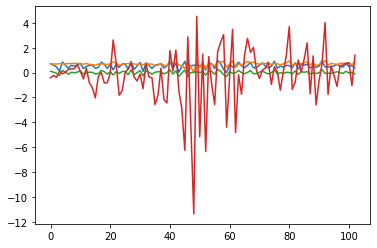

In [101]:
directory = '../data/'

df = pd.read_csv(directory + "stocks_and_sentiment_2020.csv", sep=";", names=['date','sentiment','price'], encoding="ISO-8859-1")
df = df.iloc[:, 1:3]
df.head()

df_diff = df.copy()
df_diff["sentiment_diff"] = df["sentiment"].diff()
df_diff = df_diff.dropna()
df_diff = df_diff[["sentiment_diff", "price"]]


from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))

X = scaler.fit_transform(df_diff.values)
X_sent_asoc = X[:,0][:-future_steps]
X_prices = X[:,1][:-future_steps]
X_prices_next = X[:,1]


plt.plot(X)
plt.plot(scaler.inverse_transform(X))


    
num_steps = 7
future_steps = 1


X = np.array(create_window_data_arrays((X_sent_asoc, X_prices), num_steps))
Y = create_window_data_array_with_shift(X_prices_next,future_steps, num_steps +future_steps)
print(X.shape, Y.shape)

In [102]:
train_X, test_X, train_y, test_y = train_test_split(
X, Y, test_size=0.20, random_state=1000)

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(76, 7, 2) (76, 1) (19, 7, 2) (19, 1)


Train on 76 samples, validate on 19 samples
Epoch 1/100
 - 1s - loss: 0.6278 - accuracy: 0.0132 - val_loss: 0.5201 - val_accuracy: 0.0000e+00
Epoch 2/100
 - 0s - loss: 0.3951 - accuracy: 0.0132 - val_loss: 0.2298 - val_accuracy: 0.0000e+00
Epoch 3/100
 - 0s - loss: 0.2806 - accuracy: 0.0263 - val_loss: 0.1180 - val_accuracy: 0.0000e+00
Epoch 4/100
 - 0s - loss: 0.2420 - accuracy: 0.0000e+00 - val_loss: 0.1017 - val_accuracy: 0.0000e+00
Epoch 5/100
 - 0s - loss: 0.2663 - accuracy: 0.0263 - val_loss: 0.1306 - val_accuracy: 0.0000e+00
Epoch 6/100
 - 0s - loss: 0.2306 - accuracy: 0.0263 - val_loss: 0.1603 - val_accuracy: 0.0000e+00
Epoch 7/100
 - 0s - loss: 0.2217 - accuracy: 0.0132 - val_loss: 0.1598 - val_accuracy: 0.0000e+00
Epoch 8/100
 - 0s - loss: 0.1975 - accuracy: 0.0263 - val_loss: 0.1390 - val_accuracy: 0.0000e+00
Epoch 9/100
 - 0s - loss: 0.2131 - accuracy: 0.0132 - val_loss: 0.1172 - val_accuracy: 0.0000e+00
Epoch 10/100
 - 0s - loss: 0.2422 - accuracy: 0.0263 - val_loss: 0.116

Epoch 83/100
 - 0s - loss: 0.1336 - accuracy: 0.0132 - val_loss: 0.1107 - val_accuracy: 0.0000e+00
Epoch 84/100
 - 0s - loss: 0.1234 - accuracy: 0.0132 - val_loss: 0.1111 - val_accuracy: 0.0000e+00
Epoch 85/100
 - 0s - loss: 0.1342 - accuracy: 0.0132 - val_loss: 0.1243 - val_accuracy: 0.0000e+00
Epoch 86/100
 - 0s - loss: 0.1393 - accuracy: 0.0132 - val_loss: 0.1200 - val_accuracy: 0.0000e+00
Epoch 87/100
 - 0s - loss: 0.1193 - accuracy: 0.0132 - val_loss: 0.1132 - val_accuracy: 0.0000e+00
Epoch 88/100
 - 0s - loss: 0.1346 - accuracy: 0.0132 - val_loss: 0.1123 - val_accuracy: 0.0000e+00
Epoch 89/100
 - 0s - loss: 0.1353 - accuracy: 0.0132 - val_loss: 0.1176 - val_accuracy: 0.0000e+00
Epoch 90/100
 - 0s - loss: 0.1457 - accuracy: 0.0132 - val_loss: 0.1161 - val_accuracy: 0.0000e+00
Epoch 91/100
 - 0s - loss: 0.1419 - accuracy: 0.0132 - val_loss: 0.1144 - val_accuracy: 0.0000e+00
Epoch 92/100
 - 0s - loss: 0.1210 - accuracy: 0.0132 - val_loss: 0.1134 - val_accuracy: 0.0000e+00
Epoch 93/1

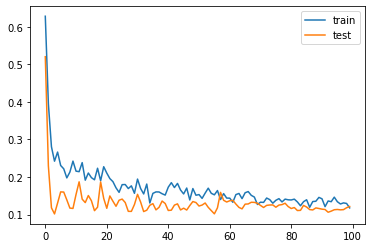

In [103]:
output_size = future_steps
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.6))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.6))
model.add(Dense(output_size))

model.compile(loss='mae', optimizer='adam',metrics=['accuracy'])
csv_logger = CSVLogger('log_loss.csv', append=True, separator=';')
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=10, validation_data=(test_X, test_y), verbose=2, shuffle=False, callbacks=[csv_logger])
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [108]:

#https://datascience.stackexchange.com/a/45172
from sklearn.metrics import classification_report
from sklearn.metrics import mean_absolute_error

y_pred = model.predict(test_X, batch_size=100, verbose=1)
print(mean_absolute_error(test_y, y_pred))

M = np.column_stack((test_y, y_pred))
M_untransformed = scaler.inverse_transform(M)

#y_pred_un = scaler.inverse_transform(y_pred.reshape((len(y_pred),1)))
#test_y_un = scaler.inverse_transform(test_y.reshape((len(test_y),1)))

print(M_untransformed)

print(df_diff.values[-3:])



19/19 [==============================] - 0s 86us/step
0.12142507706230203
[[ 0.08877445 -0.66255841]
 [ 0.11510278 -0.68223701]
 [ 0.04795798 -0.54239004]
 [ 0.13140126 -0.59398854]
 [-0.0506398  -0.70466644]
 [ 0.10902699 -0.68151849]
 [ 0.20824834 -0.45077366]
 [ 0.00645864 -0.54400433]
 [ 0.15340359 -0.64516996]
 [ 0.11952735 -0.72598397]
 [ 0.23860575 -0.69480723]
 [ 0.16203683 -0.62348179]
 [ 0.00542209 -0.7032351 ]
 [ 0.10640734 -0.50361771]
 [ 0.10255747 -0.8256993 ]
 [ 0.12182777 -0.61519707]
 [ 0.16865069 -0.64641741]
 [ 0.2509833  -0.44079217]
 [ 0.15284763 -0.63967588]]
[[-0.02662816  0.8008812 ]
 [ 0.01161176 -1.04792342]
 [-0.09596542  1.39561073]]
